# Mask generating algorithm

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Load Model

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier


# Load MaskGeneratingModel

In [66]:
from maskgen.models.vision_maskgen_model7 import MaskGeneratingModel
# from maskgen.models.mask_generating_model12 import MaskGeneratingModel
mask_gen_model = MaskGeneratingModel(pred_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
# mask_gen_model.load_state_dict(torch.load('trained/vision_maskgen_model3/mask_gen_model_2_90.pth'))
# mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_final_9_195.pth'))
mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_1_40.pth'))
# mask_gen_model.load_state_dict(torch.load('trained/mask_gen_model12/mask_gen_model_2_90.pth'))
mask_gen_model.eval()

# patch_size = 14
patch_size = 16
print()

## Show Example

# Demo trained examples

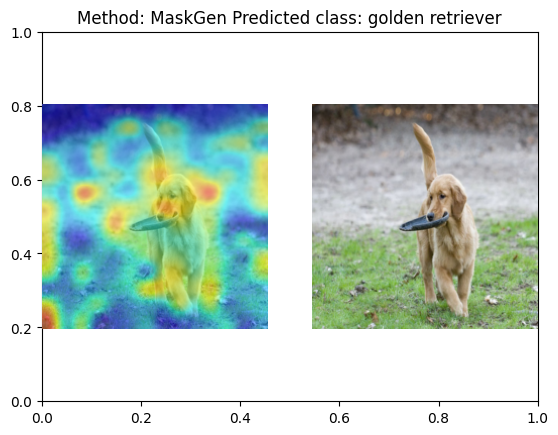

In [70]:
from maskgen.utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=patch_size)
heatmap = mask_gen_model.attribute_img(img)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [52]:
print("min", heatmap.min())
print("max", heatmap.max())

min 0.2443216
max 0.6928228


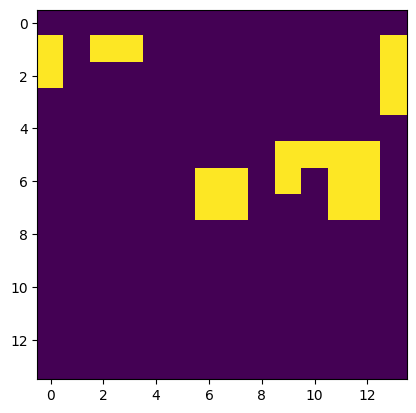

In [54]:
# test_mask = obtain_masks_on_topk(heatmap, 20, 'ins')
plt.imshow((heatmap > np.quantile(heatmap, 0.9)))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.show()

# Batch Evaluation

In [166]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 1000
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [167]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

# n_samples = 100

# random_mask
root_path = 'results/maskgen_model3-vit'

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    attr = mask_gen_model.attribute_img(pixel_values)

    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    # if (idx + 1) * batch_size % 100 == 0:
    #     heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
    #     save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
    #     heatmap_list = []


if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)

# heatmap = heatmap_list

5it [01:20, 16.18s/it]


# Get accuracy of the topk masked inputs

In [168]:
import torch 
import numpy as np
from torch.nn import functional as F

# hm_path = 'results/maskgen-vit/heatmap-5000.npy'
# hm_path = 'results/rise-vit/heatmap-5000.npy'
hm_path = 'results/maskgen_model3-vit/heatmap-5000.npy'

def obtain_masks_on_topk(attribution, topk, mode='positive'):
    """ 
    attribution: [N, H_a, W_a]
    """
    H_a, W_a = attribution.shape[-2:]
    attribution = attribution.reshape(-1, H_a * W_a) # [N, H_a*W_a]
    attribution_perturb = attribution + 1e-6*torch.randn_like(attribution) # to avoid equal attributions (typically all zeros or all ones)
    
    attribution_size = H_a * W_a
    topk_scaled = int(topk * attribution_size / 100)
    if mode == 'positive':
        a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1)
        a = a[:, -1].unsqueeze(-1)
        mask = (attribution_perturb <= a).float()
    elif mode == 'negative':
        a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1, largest=False)
        a = a[:, -1].unsqueeze(-1)
        mask = (attribution_perturb >= a).float()
        # a, _ = torch.topk(attribution_perturb, k=topk_scaled, dim=-1)
        # a = a[:, -1].unsqueeze(-1)
        # mask = (attribution_perturb >= a).float()

    else:
        raise ValueError('Enter game mode either as positive or negative.')
    return mask.reshape(-1, H_a, W_a) # [N, H_a*W_a]


def obtain_masked_input_on_topk(x, attribution, topk, mode='positive'):
    """ 
    x: [N, C, H, W]
    attribution: [N, H_a, W_a]
    """
    mask = obtain_masks_on_topk(attribution, topk, mode)
    mask = mask.unsqueeze(1) # [N, 1, H_a, W_a]
    mask = F.interpolate(mask, size=x.shape[-2:], mode='nearest')

    masked_input = x * mask

    # mean_pixel = masked_input.sum(dim=(-1, -2), keepdim=True) / mask.sum(dim=(-1, -2), keepdim=True)
    mean_pixel = x.mean(dim=(-1, -2), keepdim=True)
    masked_input = masked_input + (1 - mask) * mean_pixel

    return masked_input

def load_heatmap(path='results/maskgen-vit/heatmap-5000.npy', batch_size=1000):
    heatmap = np.load(path)
    heatmap = torch.tensor(heatmap) # [N, 1, 14, 14]
    batches = torch.split(heatmap, batch_size, dim=0)
    return batches


topk = 20
# divide heatmap into batches of size batch_size
heatmap_batches = load_heatmap(path=hm_path, batch_size=1000)

total_acc = []
for topk in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    for idx, data in tqdm(enumerate(zip(test_dataloader, heatmap_batches))):
        pixel_values = data[0]['pixel_values'].to(device) # [N, C, H, W]
        attribution = data[1].to(device) # [N, 1, 14, 14]
        with torch.no_grad():
            pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)
            masked_input = obtain_masked_input_on_topk(pixel_values, attribution, topk, mode='positive')
            logits = pred_model(masked_input).logits
            preds = logits.argmax(-1).view(-1)
            acc = (pseudo_label == preds).float().mean().item()
            print(acc)
            total_acc.append(acc)
            break
        


0it [00:11, ?it/s]


0.8530000448226929


0it [00:13, ?it/s]


0.7560000419616699


0it [00:00, ?it/s]

In [ ]:
sum(total_acc) / len(total_acc)

# negative
# 0.7702222632037269
# positive
# 0.30455556470486855

0.30455556470486855

In [ ]:
total_acc

# negative
# [0.9530000686645508,
#  0.9160000681877136,
#  0.8950000405311584,
#  0.8760000467300415,
#  0.8440000414848328,
#  0.8100000619888306,
#  0.7210000157356262,
#  0.597000002861023,
#  0.320000022649765] = 0.7702222632037269

# posivie
# [0.7760000228881836,
#  0.6050000190734863,
#  0.453000009059906,
#  0.3400000035762787,
#  0.2330000102519989,
#  0.16700001060962677,
#  0.08900000154972076,
#  0.06100000441074371,
#  0.017000000923871994] = 0.30455556470486855


[0.7760000228881836,
 0.6050000190734863,
 0.453000009059906,
 0.3400000035762787,
 0.2330000102519989,
 0.16700001060962677,
 0.08900000154972076,
 0.06100000441074371,
 0.017000000923871994]

In [ ]:
# ins_score = torch.stack(ins_score_list)
# del_score = torch.stack(del_score_list)

# print(ins_score.mean())
# print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# tensor(0.6749, device='cuda:0')
# tensor(0.0431, device='cuda:0')

RuntimeError: stack expects a non-empty TensorList

Predicted class: red wine


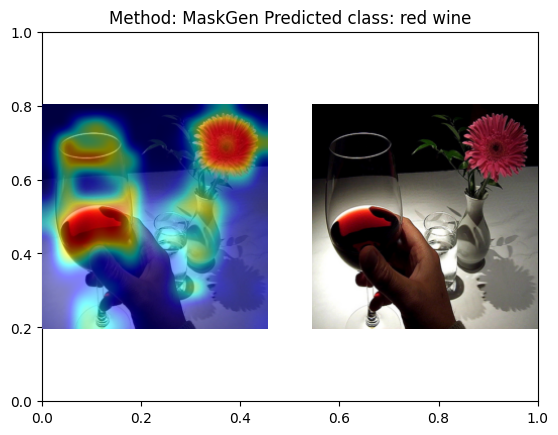

In [ ]:
from maskgen.utils.img_utils import plot_overlap_np

idx = 19
predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = attribution[idx].detach().cpu().numpy()
img = pixel_values[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# plt.annotate(f"ins_score: {ins_score[-1]:.4f}", (0, 10))
# plt.annotate(f"del_score: {del_score[-1]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

# print("ins_score:", ins_score[-1])
# print("del_score:", del_score[-1])

In [ ]:
heatmap[0]

tensor([[0.0529, 0.0596, 0.0616, 0.0572, 0.0551, 0.0536, 0.0534, 0.0534, 0.0535,
         0.0544, 0.0570, 0.0555, 0.0559, 0.0526],
        [0.0548, 0.0601, 0.0621, 0.0693, 0.0596, 0.0602, 0.0623, 0.2657, 0.0650,
         0.1217, 0.0745, 0.0696, 0.0722, 0.0531],
        [0.0631, 0.0615, 0.0624, 0.0717, 0.1387, 0.0691, 0.0832, 0.0963, 0.2872,
         0.1031, 0.0990, 0.0536, 0.0795, 0.0538],
        [0.0659, 0.0709, 0.0534, 0.0971, 0.2781, 0.1260, 0.1436, 0.2516, 0.3691,
         0.2105, 0.2359, 0.1109, 0.1150, 0.0522],
        [0.0602, 0.3013, 0.0883, 0.0897, 0.1449, 0.3571, 0.5239, 0.2836, 0.2990,
         0.1364, 0.2019, 0.1568, 0.1421, 0.0553],
        [0.0588, 0.0536, 0.0531, 0.0531, 0.0532, 0.2843, 0.2353, 0.2546, 0.3584,
         0.2408, 0.3029, 0.2352, 0.1841, 0.0553],
        [0.0566, 0.0651, 0.0532, 0.0532, 0.2212, 0.2338, 0.3536, 0.4105, 0.2424,
         0.2132, 0.2709, 0.2007, 0.1651, 0.0563],
        [0.0573, 0.2237, 0.1341, 0.2098, 0.3592, 0.4132, 0.2990, 0.2717, 0.2514,
  

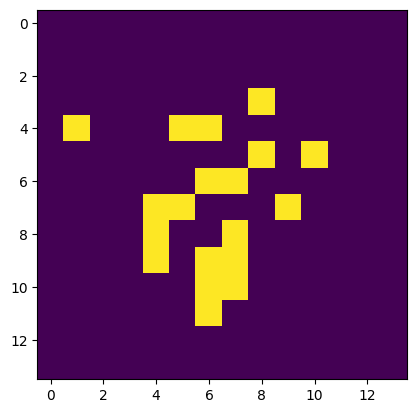

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


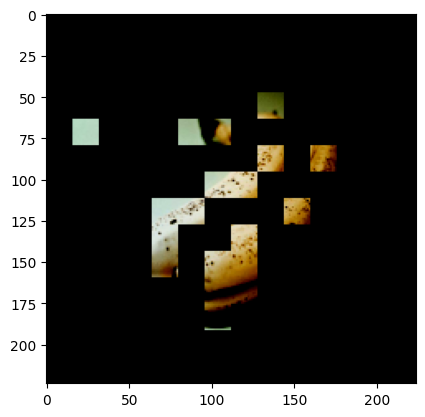

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


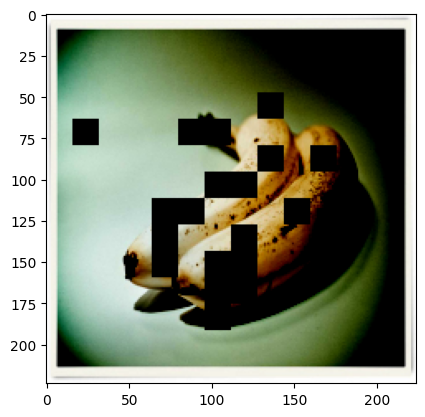

In [ ]:
from maskgen.evaluation import obtain_masks_on_topk, obtain_masked_input_on_topk

test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]

mode = 'ins'
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode)
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode)
test_masked_img2 = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')

# plt.imshow((heatmap[idx] > torch.quantile(heatmap[idx], 0.8)).float().cpu().numpy())
plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
plt.show()
plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(test_masked_img2[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [ ]:
from maskgen.evaluation import EvalGame, obtain_masks_on_topk, obtain_masked_input_on_topk
test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]
# eval_game.get_deletion_at_topk(test_img, test_heatmap, topk)
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode='del')
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk)
 # [N, 1, H_a, W_a]
resized_mask = F.interpolate(test_mask.unsqueeze(1), size=test_img.shape[-2:], mode='nearest')

test_predicted_class_idx = pred_model(test_masked_img).logits.argmax(-1)
print("Predicted class:", pred_model.config.id2label[test_predicted_class_idx.item()])

# probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
# print(eval_game.get_score_at_topk(test_img, test_heatmap, 20, mode='del'))

test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')
probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
print(probs[:,439])


test_masked_img = obtain_masked_input_on_topk(test_img, test_mask, topk)


pseudo_label = self.model(x).argmax(-1) # [1, 1]
probs = torch.softmax(self.model(masked_input), dim=-1) # [N, 1000]

selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]
probs = (probs * selector).sum(-1) # [N,]
return probs # [N,]



plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.imshow((test_masked_img * resized_mask)[0].detach().cpu().numpy().transpose(1, 2, 0))

Predicted class: wing
tensor([4.2913e-08], device='cuda:0')


NameError: name 'self' is not defined

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)